In [ ]:
pip install yfinance pandas numpy scipy


In [ ]:
pip install yfinance pandas matplotlib


In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize



#PORTAFOLIO VS INDICE

[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  1 of 1 completed


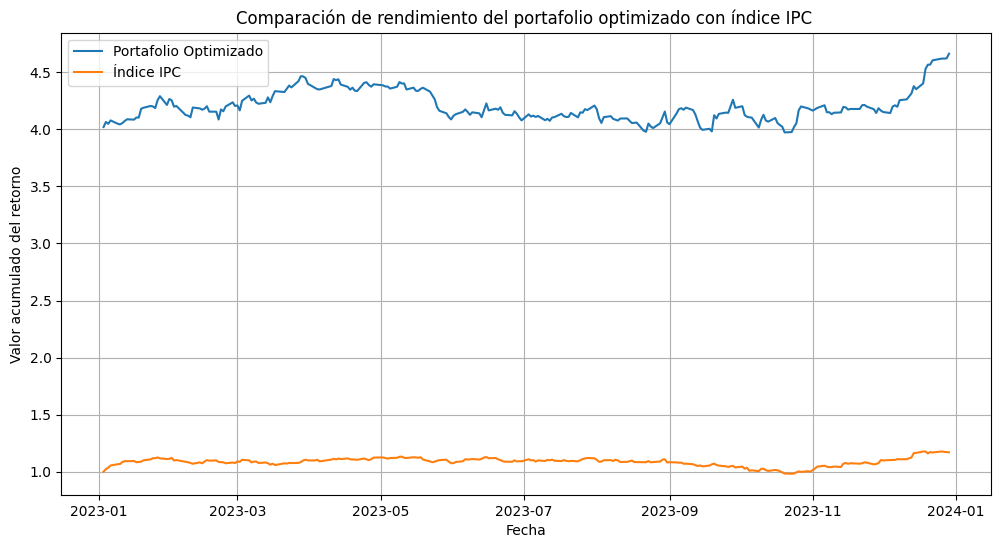

In [5]:
# Definir los tickers de los activos del portafolio y del índice
tickers_portafolio = ["WALMEX.MX","SORIANAB.MX","LACOMERUBC.MX","CHDRAUIB.MX"]
ticker_indice = '^MXX'  # Ticker del IPC
# Obtener datos
datos_portafolio = yf.download(tickers_portafolio, start='2023-01-01', end='2024-01-01')['Adj Close']
datos_indice = yf.download(ticker_indice, start='2023-01-01', end='2024-01-01')['Adj Close']
# Calcular los retornos diarios
retorno_diario_portafolio = datos_portafolio.pct_change().dropna()
retorno_diario_indice = datos_indice.pct_change().dropna()
# Calcular los retornos acumulativos
retorno_acum_portafolio = (1 + retorno_diario_portafolio).cumprod()
retorno_acum_indice = (1 + retorno_diario_indice).cumprod()
# Graficar los retornos acumulativos
plt.figure(figsize=(12, 6))
plt.plot(retorno_acum_portafolio.index, retorno_acum_portafolio.sum(axis=1), label='Portafolio Optimizado')
plt.plot(retorno_acum_indice.index, retorno_acum_indice, label='Índice IPC')
plt.title('Comparación de rendimiento del portafolio optimizado con índice IPC ')
plt.xlabel('Fecha')
plt.ylabel('Valor acumulado del retorno')
plt.legend()
plt.grid(True)
plt.show()



#ACTIVO LIBRE DE RIESGO

[*********************100%%**********************]  5 of 5 completed


Pesos óptimos del portafolio:
WALMEX.MX: 0.3378
SORIANAB.MX: 0.1790
LACOMERUBC.MX: 0.2052
CHDRAUIB.MX: 0.2781

Rendimiento y riesgo del portafolio óptimo:
Rendimiento esperado: 0.0748
Desviación estándar esperada: 0.1517


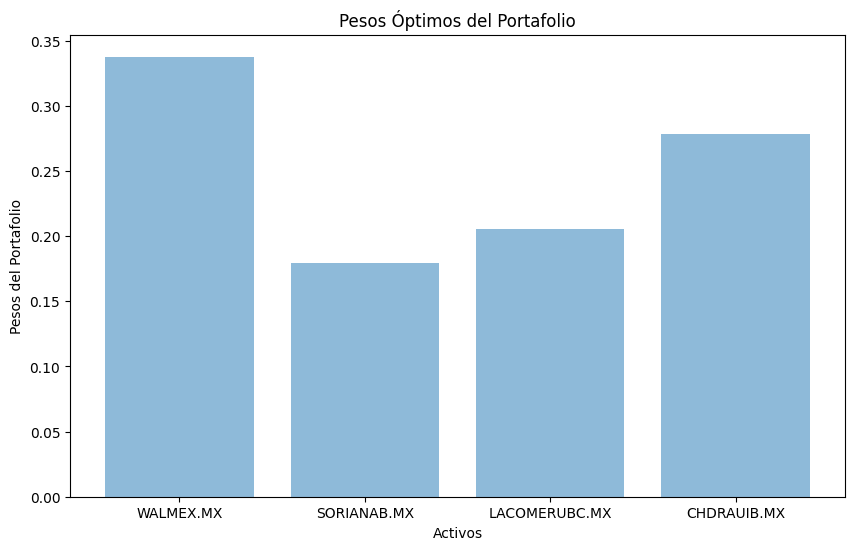

In [17]:
tickers = ["WALMEX.MX", "SORIANAB.MX", "LACOMERUBC.MX", "CHDRAUIB.MX"]  # Activos riesgosos
rf_ticker = 'MONEXCPBMC-3.MX'  # Activo libre de riesgo
data = yf.download(tickers + [rf_ticker], start='2023-05-01', end='2024-05-01')['Adj Close']

# Separar los datos de los activos riesgosos y del activo libre de riesgo
returns = data.pct_change().dropna()
returns_rf = returns[rf_ticker]
returns = returns.drop(columns=[rf_ticker])

# Calcular rendimientos esperados y matriz de covarianza de los activos riesgosos
expected_returns = returns.mean() * 365
cov_matrix = returns.cov() * 365

# Función objetivo para minimizar la volatilidad del portafolio
def objective(weights, cov_matrix, risk_free_rate):
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    return np.sqrt(portfolio_variance)

# Restricciones
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
bounds = tuple((0, 1) for asset in range(len(tickers)))
initial_guess = np.array([1.0 / len(tickers)] * len(tickers))

# Función de optimización
opt_results = minimize(objective, initial_guess, args=(cov_matrix, returns_rf.mean()), method='SLSQP', constraints=constraints, bounds=bounds)

# Obtener los pesos óptimos del portafolio
optimal_weights = opt_results.x

print("Pesos óptimos del portafolio:")
for i in range(len(tickers)):
    print(f"{tickers[i]}: {optimal_weights[i]:.4f}")

# Calcular el rendimiento y la volatilidad del portafolio óptimo
portfolio_return = np.sum(expected_returns * optimal_weights) + np.sum(returns_rf.mean() * optimal_weights)
portfolio_std_dev = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))

print("\nRendimiento y riesgo del portafolio óptimo:")
print(f"Rendimiento esperado: {portfolio_return:.4f}")
print(f"Desviación estándar esperada: {portfolio_std_dev:.4f}")

# Gráfica
plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights, align='center', alpha=0.5)
plt.xlabel('Activos')
plt.ylabel('Pesos del Portafolio')
plt.title('Pesos Óptimos del Portafolio')
plt.show()
